In [53]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model

# Загружаем данные Fashion MNIST
(fashion_train_data, _), (fashion_test_data, _) = fashion_mnist.load_data()

# Нормализация данных Fashion MNIST
fashion_train_data = fashion_train_data.astype('float32') / 255.
fashion_test_data = fashion_test_data.astype('float32') / 255.

# Загружаем данные MNIST
(nums_train_data, _), (nums_test_data, _) = mnist.load_data()

# Нормализация данных MNIST
nums_train_data = nums_train_data.astype('float32') / 255
nums_test_data = nums_test_data.astype('float32') / 255

# Объединение тестовых данных Fashion MNIST и MNIST в одну переменную
test_data = np.concatenate((fashion_test_data, nums_test_data), axis=0)

# Создание меток

fashion_labels = np.ones(fashion_test_data.shape[0], dtype=bool)  # True для fashion_test_data
nums_labels = np.zeros(nums_test_data.shape[0], dtype=bool)        # False для nums_test_data
test_labels = np.concatenate((fashion_labels, nums_labels), axis=0)

# Перемешивание данных и меток
indices = np.arange(test_data.shape[0])
np.random.shuffle(indices)

test_data = test_data[indices]
test_labels = test_labels[indices]

print(fashion_train_data.shape, len(test_data), len(test_labels))


(60000, 28, 28) 20000 20000


Теперь напишем AnomalyDetector

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.2927 - val_loss: 0.1454
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.1314 - val_loss: 0.1303
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.1070 - val_loss: 0.1153
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0929 - val_loss: 0.1061
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0872 - val_loss: 0.1014
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0824 - val_loss: 0.0983
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0801 - val_loss: 0.0965
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0776 - val_loss: 0.0958
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 0.0763 - val_loss: 0.0938
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0748 - val_loss: 0.0926
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0733 - val_loss: 0.0918
Epoch 12/20
118/118 ━━━━━━━━━━━━━━━━━

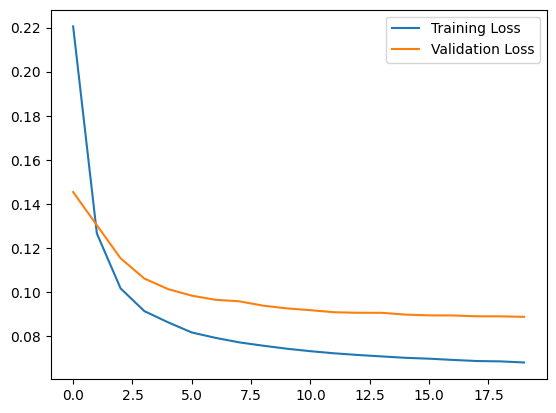

In [54]:
class AnomalyDetector(Model):

    def __init__(self):

        super(AnomalyDetector, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),  # 28x28 -> 14x14
            layers.Conv2D(32, (3, 3), activation='relu'), 
            layers.MaxPooling2D((2, 2)),  # 14x14 -> 7x7
            layers.Conv2D(32, (3, 3), activation='relu'),  # 7x7 -> 5x5
            layers.Flatten(),
            layers.Dense(10, activation='softmax')  # Упрощенный выход

        ])


        self.decoder = tf.keras.Sequential([
            layers.Dense(7 * 7 * 32, activation='relu'),  # Восстановление до 7x7x32
            layers.Reshape((7, 7, 32)),  # Изменение формы
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),  # 7x7 -> 9x9
            layers.UpSampling2D((2, 2)),  # 9x9 -> 18x18
            layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same'),  # 18x18 -> 20x20
            layers.UpSampling2D((2, 2)),  # 20x20 -> 40x40
            layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')  # 40x40 -> 28x28

        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(fashion_train_data, fashion_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


Detect anomalys

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


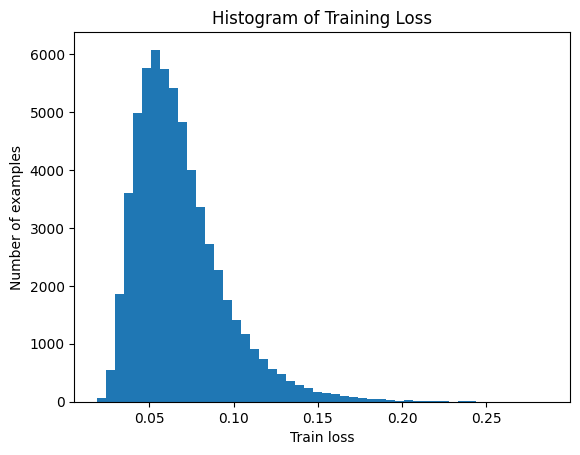

In [55]:
reconstructions = autoencoder.predict(fashion_train_data)

if fashion_train_data.ndim == 3:
    fashion_train_data = np.expand_dims(fashion_train_data, axis=-1)  # Преобразуем в (60000, 28, 28, 1)


# Вычисляем среднюю абсолютную ошибку
train_loss = np.mean(np.abs(reconstructions - fashion_train_data), axis=(1, 2, 3))


# Строим гистограмму
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("Number of examples")
plt.title("Histogram of Training Loss")
plt.show()

In [56]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.0949288


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


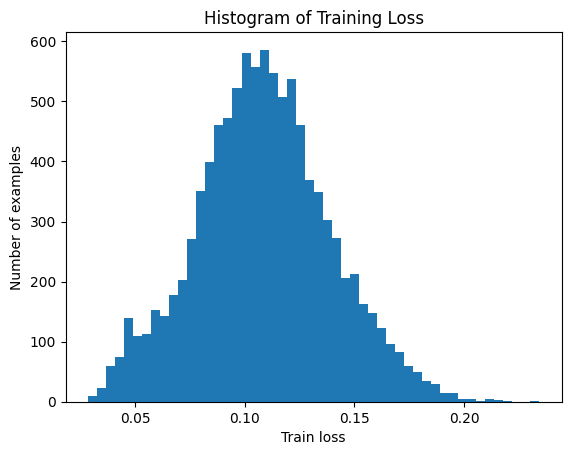

In [57]:
reconstructions = autoencoder.predict(nums_test_data)

nums_test_data = np.expand_dims(nums_test_data, axis=-1)  # Преобразуем в (60000, 28, 28, 1)


# Вычисляем среднюю абсолютную ошибку
train_loss = np.mean(np.abs(reconstructions - nums_test_data), axis=(1, 2, 3))


# Строим гистограмму
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("Number of examples")
plt.title("Histogram of Training Loss")
plt.show()

tf.Tensor(
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True False ...  True  True  True]], shape=(20000, 28), dtype=bool) [False False False ... False  True  True]


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets